# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je do 8. 5. 2023, 23:59:59**, pokud odevzdáte úkol do 14. 5. 2023, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **predikce labelu**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [1]:
### odtud už je to Vaše
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("train.csv")
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0


Nejdříve se podívám na některé obrazky.

In [3]:
def to_photo(row: pd.DataFrame):
    photo = row.loc[:, row.columns != 'label'].to_numpy()
    
    return np.reshape(photo, (28, 28))

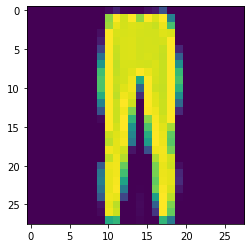

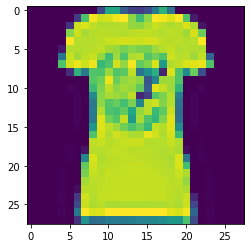

In [4]:
for i in data.label.unique():
    photo = to_photo(data[data.label == i].iloc[[1]])
    plt.figure()
    plt.imshow(photo)
    plt.show()

Teď se podívam na pixely, které silně korelují s nekterým z výsledků.

In [5]:
threshold = 0.75
data.corr()[(data.corr().label > threshold) | (data.corr().label < -threshold)]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
label,1.000000,-0.020434,-0.054130,-0.092082,-0.048170,-0.042398,-0.025555,-0.034442,-0.066190,-0.089574,...,-0.215104,-0.513664,-0.508828,-0.313084,-0.110354,-0.028087,-0.033589,-0.016547,0.015641,-0.023236
pixel175,-0.756263,0.027829,0.058285,0.077553,0.014858,0.031551,0.069953,0.114317,0.160890,0.117096,...,0.299597,0.553426,0.544135,0.331564,0.162860,0.117286,0.051807,0.012153,-0.001328,-0.011438
pixel203,-0.758236,0.029305,0.056316,0.117938,0.052570,0.030976,0.064219,0.108804,0.154177,0.104562,...,0.292854,0.551608,0.544223,0.330506,0.158450,0.115119,0.057975,0.020595,0.001894,-0.012058
pixel204,-0.754954,0.026255,0.051989,0.101528,0.053627,0.043248,0.051037,0.118631,0.181144,0.207935,...,0.304083,0.561446,0.536956,0.338544,0.165874,0.105733,0.054260,0.014869,0.003508,0.019610
pixel231,-0.753898,0.020845,0.055136,0.124194,0.053750,0.023708,0.061346,0.101999,0.151400,0.103360,...,0.284992,0.541852,0.539203,0.328118,0.161509,0.116833,0.062689,0.023411,0.016462,0.013398
pixel232,-0.765573,0.025955,0.040187,0.100376,0.051272,0.038038,0.062441,0.101066,0.153858,0.175214,...,0.292407,0.552151,0.525192,0.330573,0.169359,0.105201,0.057039,0.022213,0.015194,0.032725
pixel246,-0.755446,0.018944,0.056678,0.108893,0.048642,0.032005,0.060021,0.090678,0.128820,0.119595,...,0.289113,0.554200,0.540121,0.338114,0.172848,0.097967,0.062365,0.020720,0.006767,0.010984
pixel491,-0.759685,0.026846,0.044525,0.089514,0.049347,0.064156,0.044037,0.046149,0.081810,0.093037,...,0.234402,0.505008,0.496172,0.318182,0.130478,0.044653,0.036822,0.009741,-0.013768,0.023325
pixel519,-0.769343,0.027264,0.049162,0.094201,0.052330,0.059599,0.030814,0.035788,0.067846,0.083427,...,0.250227,0.516321,0.507050,0.319291,0.122803,0.038488,0.057256,0.035986,-0.000316,0.022143
pixel547,-0.781871,0.026990,0.047169,0.094420,0.056191,0.056345,0.033066,0.044294,0.073415,0.086893,...,0.246744,0.514984,0.505990,0.318577,0.128844,0.037430,0.044620,0.023254,-0.009271,0.026482


Spousta pixelů má silné korelace, predvším k výsledku tričko, podívám se tedy na graf dvou vzdálené vypadajících pixelů.

In [ ]:
fig, ax = plt.subplots()
pixel_y = 'pixel175'
pixel_x = 'pixel631'
colour = {0: 'red', 1:'blue'}
ax.scatter(data[pixel_x], data[pixel_y], c=data.label.map(colour))
ax.set_xlabel(pixel_x)
ax.set_ylabel(pixel_y)

Je zde vidět silné oddělení množin, ale i silná korelace daných dvou pixelů. Datasety s hodntou kalhot se však drží silné u hran. Podívám se tudíž na extrémní hodnoty, které se hran nedrží.

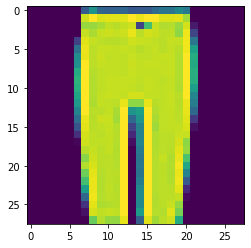

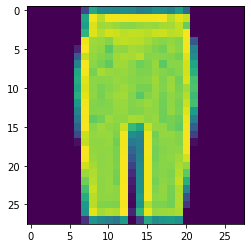

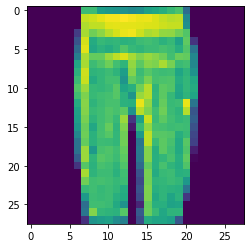

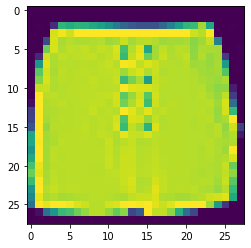

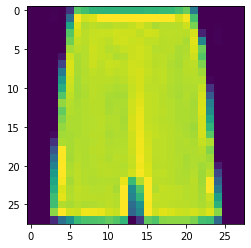

In [7]:
for i in range(len(data[(data.pixel631 > 50) & (data.pixel175 > 50) & (data.label == 1)].index)):
    photo = to_photo(data[(data.pixel631 > 50) & (data.pixel175 > 50) & (data.label == 1)].iloc[[i]])
    plt.figure()
    plt.imshow(photo)
    plt.show()

Jak lze vidět, mimo hrany se drželi především specifické typy kalhot (velmi široké kalhoty, sukně a kraťasy)

In [8]:
t1 = data[data.label == 1].sum().to_numpy()[1:]
t1.shape

(784,)

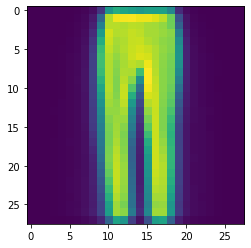

In [9]:
plt.figure()
plt.imshow(np.reshape(t1, (28, 28)))
plt.show()

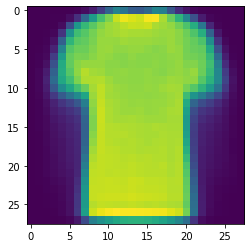

In [10]:
t2 = data[data.label == 0].sum().to_numpy()[1:]
plt.figure()
plt.imshow(np.reshape(t2, (28, 28)))
plt.show()

In [11]:
corr_photo = np.reshape(data.corr().label[1:].to_numpy(), (28, 28))

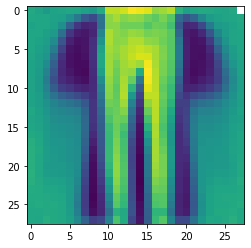

In [12]:
plt.figure()
plt.imshow(corr_photo)
plt.show()

Jakožto hlavní oblasti rozhodující o tom, zda se jedná o kalhoty či triko, se zdají být místa, kde triko přebývá oproti kalhotám, jedná se především o rukávy a mezeru mezi nohavicemi. Mezitím kalhotz mají výšší výskyt s pixely, kolem míst, kde trika, obvykle mívají potisky, a uprostřed horní řady pixelů, kde trika mívají volné místo.

Teď vytvoříme normalizovanou verzi dat.

In [13]:
def normalize(row: pd.Series):
    return (row - min(row)) / (max(row) - min(row))
data_norm = data.copy()
data_norm.iloc[:, 1:] = data_norm.iloc[:,1:].apply(normalize, axis=1)
display(data.head())
display(data_norm.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.003922,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.003922,0.007843,0.003922,0.015686,0.007843,0.0,0.0,...,0.145098,0.286275,0.254902,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.411765,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.529412,0.529412,0.721569,0.231373,0.0,0.007843,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.274510,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [14]:
from sklearn.model_selection import train_test_split
train_data_norm, test_data_norm = train_test_split(data_norm)
train_first_norm, val_data_norm = train_test_split(train_data_norm)

train_data, test_data = train_test_split(data)
train_first, val_data = train_test_split(train_data)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
def train_grid(data: pd.DataFrame, pipe: Pipeline, params: dict) -> GridSearchCV:
    clf = GridSearchCV(pipe, params, verbose=5)
    clf.fit(data.iloc[:,1:], data.label)
    
    print()
    print()
    print(clf.best_score_)
    print(clf.best_params_)
    return clf
    

In [16]:
from sklearn.svm import SVC
svc_parameters = {'kernel':('linear', 'rbf'), 'C':list(np.arange(0.1, 10, 0.2))}
svc_simple = SVC()
grid_svc_simple = train_grid(train_first, svc_simple, svc_parameters)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.985 total time=   0.2s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.970 total time=   0.1s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.978 total time=   0.1s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.996 total time=   0.2s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.974 total time=   0.1s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.959 total time=   0.5s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.970 total time=   0.5s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.978 total time=   0.5s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.974 total time=   0.4s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.952 total time=   0.6s
[CV 1/5] END C=0.30000000000000004, kernel=linear;, score=0.985 total time=   0.1s
[CV 2/5] END C=0.30000000000000004, kernel=l

[CV 1/5] END C=2.1000000000000005, kernel=linear;, score=0.985 total time=   0.1s
[CV 2/5] END C=2.1000000000000005, kernel=linear;, score=0.970 total time=   0.1s
[CV 3/5] END C=2.1000000000000005, kernel=linear;, score=0.978 total time=   0.1s
[CV 4/5] END C=2.1000000000000005, kernel=linear;, score=0.996 total time=   0.1s
[CV 5/5] END C=2.1000000000000005, kernel=linear;, score=0.974 total time=   0.1s
[CV 1/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.981 total time=   0.2s
[CV 2/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.985 total time=   0.2s
[CV 3/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.985 total time=   0.2s
[CV 4/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.989 total time=   0.2s
[CV 5/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.989 total time=   0.2s
[CV 1/5] END C=2.3000000000000007, kernel=linear;, score=0.985 total time=   0.1s
[CV 2/5] END C=2.3000000000000007, kernel=linear;, score=0.970 total time=   0.1s
[CV 3/5] END C=2.3000

[CV 2/5] END C=4.1000000000000005, kernel=linear;, score=0.970 total time=   0.1s
[CV 3/5] END C=4.1000000000000005, kernel=linear;, score=0.978 total time=   0.2s
[CV 4/5] END C=4.1000000000000005, kernel=linear;, score=0.996 total time=   0.1s
[CV 5/5] END C=4.1000000000000005, kernel=linear;, score=0.974 total time=   0.1s
[CV 1/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.981 total time=   0.2s
[CV 3/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.993 total time=   0.2s
[CV 4/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.989 total time=   0.2s
[CV 5/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.993 total time=   0.1s
[CV 1/5] END C=4.300000000000001, kernel=linear;, score=0.985 total time=   0.1s
[CV 2/5] END C=4.300000000000001, kernel=linear;, score=0.970 total time=   0.1s
[CV 3/5] END C=4.300000000000001, kernel=linear;, score=0.978 total time=   0.1s
[CV 4/5] END C=4.3000000

[CV 5/5] END C=6.1000000000000005, kernel=linear;, score=0.974 total time=   0.1s
[CV 1/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.985 total time=   0.2s
[CV 2/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.981 total time=   0.2s
[CV 3/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.993 total time=   0.2s
[CV 4/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.989 total time=   0.2s
[CV 5/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.993 total time=   0.1s
[CV 1/5] END C=6.300000000000001, kernel=linear;, score=0.985 total time=   0.1s
[CV 2/5] END C=6.300000000000001, kernel=linear;, score=0.970 total time=   0.1s
[CV 3/5] END C=6.300000000000001, kernel=linear;, score=0.978 total time=   0.1s
[CV 4/5] END C=6.300000000000001, kernel=linear;, score=0.996 total time=   0.1s
[CV 5/5] END C=6.300000000000001, kernel=linear;, score=0.974 total time=   0.1s
[CV 1/5] END ...C=6.300000000000001, kernel=rbf;, score=0.985 total time=   0.2s
[CV 2/5] END ...C=6.3000000

[CV 2/5] END ...C=8.100000000000001, kernel=rbf;, score=0.981 total time=   0.2s
[CV 3/5] END ...C=8.100000000000001, kernel=rbf;, score=0.993 total time=   0.2s
[CV 4/5] END ...C=8.100000000000001, kernel=rbf;, score=0.989 total time=   0.2s
[CV 5/5] END ...C=8.100000000000001, kernel=rbf;, score=0.993 total time=   0.1s
[CV 1/5] END ..............C=8.3, kernel=linear;, score=0.985 total time=   0.1s
[CV 2/5] END ..............C=8.3, kernel=linear;, score=0.970 total time=   0.1s
[CV 3/5] END ..............C=8.3, kernel=linear;, score=0.978 total time=   0.1s
[CV 4/5] END ..............C=8.3, kernel=linear;, score=0.996 total time=   0.2s
[CV 5/5] END ..............C=8.3, kernel=linear;, score=0.974 total time=   0.1s
[CV 1/5] END .................C=8.3, kernel=rbf;, score=0.985 total time=   0.2s
[CV 2/5] END .................C=8.3, kernel=rbf;, score=0.981 total time=   0.2s
[CV 3/5] END .................C=8.3, kernel=rbf;, score=0.993 total time=   0.3s
[CV 4/5] END ...............

In [17]:
grid_svc_simple_norm = train_grid(train_first_norm, svc_simple, svc_parameters)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.985 total time=   0.1s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.989 total time=   0.2s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.985 total time=   0.3s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.981 total time=   0.2s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.985 total time=   0.2s
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.978 total time=   0.5s
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.967 total time=   0.4s
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.978 total time=   0.7s
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.974 total time=   1.1s
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.959 total time=   0.6s
[CV 1/5] END C=0.30000000000000004, kernel=linear;, score=0.981 total time=   0.1s
[CV 2/5] END C=0.30000000000000004, kernel=l

[CV 2/5] END C=2.1000000000000005, kernel=linear;, score=0.985 total time=   0.1s
[CV 3/5] END C=2.1000000000000005, kernel=linear;, score=0.989 total time=   0.3s
[CV 4/5] END C=2.1000000000000005, kernel=linear;, score=0.981 total time=   0.3s
[CV 5/5] END C=2.1000000000000005, kernel=linear;, score=0.981 total time=   0.4s
[CV 1/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.985 total time=   0.8s
[CV 2/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.985 total time=   0.7s
[CV 3/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.993 total time=   0.4s
[CV 4/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.989 total time=   0.4s
[CV 5/5] END ..C=2.1000000000000005, kernel=rbf;, score=0.985 total time=   0.5s
[CV 1/5] END C=2.3000000000000007, kernel=linear;, score=0.981 total time=   0.1s
[CV 2/5] END C=2.3000000000000007, kernel=linear;, score=0.985 total time=   0.2s
[CV 3/5] END C=2.3000000000000007, kernel=linear;, score=0.989 total time=   0.2s
[CV 4/5] END C=2.3000

[CV 4/5] END C=4.1000000000000005, kernel=linear;, score=0.981 total time=   0.1s
[CV 5/5] END C=4.1000000000000005, kernel=linear;, score=0.981 total time=   0.1s
[CV 1/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.985 total time=   0.2s
[CV 2/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.985 total time=   0.2s
[CV 3/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.989 total time=   0.2s
[CV 4/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END ..C=4.1000000000000005, kernel=rbf;, score=0.985 total time=   0.4s
[CV 1/5] END C=4.300000000000001, kernel=linear;, score=0.981 total time=   0.2s
[CV 2/5] END C=4.300000000000001, kernel=linear;, score=0.985 total time=   0.1s
[CV 3/5] END C=4.300000000000001, kernel=linear;, score=0.989 total time=   0.1s
[CV 4/5] END C=4.300000000000001, kernel=linear;, score=0.981 total time=   0.1s
[CV 5/5] END C=4.300000000000001, kernel=linear;, score=0.981 total time=   0.2s
[CV 1/5] END ...C=4.300000

[CV 1/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.985 total time=   0.4s
[CV 2/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.985 total time=   0.3s
[CV 3/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.989 total time=   0.1s
[CV 4/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END ..C=6.1000000000000005, kernel=rbf;, score=0.981 total time=   0.2s
[CV 1/5] END C=6.300000000000001, kernel=linear;, score=0.981 total time=   0.2s
[CV 2/5] END C=6.300000000000001, kernel=linear;, score=0.985 total time=   0.1s
[CV 3/5] END C=6.300000000000001, kernel=linear;, score=0.989 total time=   0.2s
[CV 4/5] END C=6.300000000000001, kernel=linear;, score=0.981 total time=   0.1s
[CV 5/5] END C=6.300000000000001, kernel=linear;, score=0.981 total time=   0.1s
[CV 1/5] END ...C=6.300000000000001, kernel=rbf;, score=0.985 total time=   0.2s
[CV 2/5] END ...C=6.300000000000001, kernel=rbf;, score=0.985 total time=   0.2s
[CV 3/5] END ...C=6.30000000

[CV 3/5] END ...C=8.100000000000001, kernel=rbf;, score=0.989 total time=   0.2s
[CV 4/5] END ...C=8.100000000000001, kernel=rbf;, score=0.985 total time=   0.2s
[CV 5/5] END ...C=8.100000000000001, kernel=rbf;, score=0.981 total time=   0.2s
[CV 1/5] END ..............C=8.3, kernel=linear;, score=0.981 total time=   0.2s
[CV 2/5] END ..............C=8.3, kernel=linear;, score=0.985 total time=   0.2s
[CV 3/5] END ..............C=8.3, kernel=linear;, score=0.989 total time=   0.2s
[CV 4/5] END ..............C=8.3, kernel=linear;, score=0.981 total time=   0.1s
[CV 5/5] END ..............C=8.3, kernel=linear;, score=0.981 total time=   0.2s
[CV 1/5] END .................C=8.3, kernel=rbf;, score=0.985 total time=   0.4s
[CV 2/5] END .................C=8.3, kernel=rbf;, score=0.985 total time=   0.2s
[CV 3/5] END .................C=8.3, kernel=rbf;, score=0.989 total time=   0.2s
[CV 4/5] END .................C=8.3, kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END ...............

In [18]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
gaussian_params = {'var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2]}
grid_gauss = train_grid(train_first, gauss, gaussian_params)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END ...............var_smoothing=1e-11;, score=0.885 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-11;, score=0.889 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-11;, score=0.896 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-11;, score=0.881 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-11;, score=0.870 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-10;, score=0.896 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-10;, score=0.904 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-10;, score=0.904 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-10;, score=0.885 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-10;, score=0.870 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.904 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;

In [19]:
grid_gauss_norm = train_grid(train_first_norm, gauss, gaussian_params)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV 1/5] END ...............var_smoothing=1e-11;, score=0.889 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-11;, score=0.911 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-11;, score=0.867 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-11;, score=0.881 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-11;, score=0.885 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-10;, score=0.893 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-10;, score=0.919 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-10;, score=0.870 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-10;, score=0.896 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-10;, score=0.893 total time=   0.0s
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.900 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_params = {'store_covariance': [True, False], 'tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]}
grid_lda = train_grid(train_first, lda, lda_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..store_covariance=True, tol=1e-07;, score=0.859 total time=   1.0s
[CV 2/5] END ..store_covariance=True, tol=1e-07;, score=0.900 total time=   0.9s
[CV 3/5] END ..store_covariance=True, tol=1e-07;, score=0.874 total time=   1.3s
[CV 4/5] END ..store_covariance=True, tol=1e-07;, score=0.859 total time=   1.3s
[CV 5/5] END ..store_covariance=True, tol=1e-07;, score=0.815 total time=   1.0s
[CV 1/5] END ..store_covariance=True, tol=1e-06;, score=0.859 total time=   0.9s
[CV 2/5] END ..store_covariance=True, tol=1e-06;, score=0.863 total time=   0.9s
[CV 3/5] END ..store_covariance=True, tol=1e-06;, score=0.874 total time=   1.0s
[CV 4/5] END ..store_covariance=True, tol=1e-06;, score=0.863 total time=   1.0s
[CV 5/5] END ..store_covariance=True, tol=1e-06;, score=0.815 total time=   0.7s
[CV 1/5] END ..store_covariance=True, tol=1e-05;, score=0.859 total time=   0.8s
[CV 2/5] END ..store_covariance=True, tol=1e-05;

In [21]:
grid_lda_norm = train_grid(train_first_norm, lda, lda_params)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ..store_covariance=True, tol=1e-07;, score=0.893 total time=   0.9s
[CV 2/5] END ..store_covariance=True, tol=1e-07;, score=0.870 total time=   1.1s
[CV 3/5] END ..store_covariance=True, tol=1e-07;, score=0.856 total time=   1.1s
[CV 4/5] END ..store_covariance=True, tol=1e-07;, score=0.893 total time=   1.0s
[CV 5/5] END ..store_covariance=True, tol=1e-07;, score=0.878 total time=   1.0s
[CV 1/5] END ..store_covariance=True, tol=1e-06;, score=0.885 total time=   1.4s
[CV 2/5] END ..store_covariance=True, tol=1e-06;, score=0.870 total time=   1.0s
[CV 3/5] END ..store_covariance=True, tol=1e-06;, score=0.856 total time=   1.2s
[CV 4/5] END ..store_covariance=True, tol=1e-06;, score=0.893 total time=   0.8s
[CV 5/5] END ..store_covariance=True, tol=1e-06;, score=0.878 total time=   1.0s
[CV 1/5] END ..store_covariance=True, tol=1e-05;, score=0.885 total time=   0.8s
[CV 2/5] END ..store_covariance=True, tol=1e-05;

In [22]:
## Evaluating on validation dataset

# get params best for each method used
svm_par = grid_svc_simple.best_params_
svm_norm_par = grid_svc_simple_norm.best_params_
gauss_par = grid_gauss.best_params_
gauss_norm_par = grid_gauss_norm.best_params_
lda_par = grid_lda.best_params_
lda_norm_par = grid_lda_norm.best_params_

svm_simple = SVC(**svm_par)
svm_norm = SVC(**svm_norm_par)

gauss = GaussianNB(**gauss_par)
gauss_norm = GaussianNB(**gauss_norm_par)

lda = LinearDiscriminantAnalysis(**lda_par)
lda_norm = LinearDiscriminantAnalysis(**lda_norm_par)

X = train_first.iloc[:,1:]
y = train_first.label

svm_simple.fit(X, y)
gauss.fit(X, y)
lda.fit(X, y)

X = train_first_norm.iloc[:,1:]
y = train_first_norm.label

svm_norm.fit(X, y)
gauss_norm.fit(X, y)
lda_norm.fit(X, y)

X = val_data.iloc[:, 1:]
y = val_data.label

svm_score = svm_simple.score(X, y)
gauss_score = gauss.score(X, y)
lda_score = lda.score(X, y)

X = val_data_norm.iloc[:, 1:]
y = val_data_norm.label

svm_norm_score = svm_norm.score(X, y)
gauss_norm_score = gauss_norm.score(X, y)
lda_norm_score = lda_norm.score(X, y)

print("Scores:")
print("Non-normalized:")
print("\tsvm: {}".format(svm_score))
print("\tNB gauss: {}".format(gauss_score))
print("\tlda: {}".format(lda_score))
print("Normalized:")
print("\tsvm: {}".format(svm_norm_score))
print("\tNB gauss: {}".format(gauss_norm_score))
print("\tlda: {}".format(lda_norm_score))

Scores:
Non-normalized:
	svm: 0.9844444444444445
	NB gauss: 0.9422222222222222
	lda: 0.9733333333333334
Normalized:
	svm: 0.9911111111111112
	NB gauss: 0.9066666666666666
	lda: 0.9644444444444444


Nejlépe uzpůsobeny pro práci s zásadně neupravenými daty se prokázal svm, využívající rfb, zde si nejlépe dařilo datům normalizovaným, které dosáhli přesnosti 99,1 %.

Méně uspěšný bylo lda, kterému se vedlo o procento lépe na nenormalizovaných datech, než na datech normalizovaných.

Nejzvláštnější je poslední případ, Gaussovský naivní bayesův modelu se dařilo měl lepší výsledky na nenormalizovaných datech o téměř čtyři procenta.

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(train_first.iloc[:,1:])
total_explained = 0
for i, explained_variance_ratio in enumerate(pca.explained_variance_):
    total_explained += pca.explained_variance_ratio_[i]
    print(f"Rozptyl vysvětlený {i + 1}. hlavní komponentou: {explained_variance_ratio:.2f},\tPodíl z celku: {pca.explained_variance_ratio_[i]:.2f},\nCelkem vysvětleno {total_explained*100:.2f} %")

Rozptyl vysvětlený 1. hlavní komponentou: 1054696.12,	Podíl z celku: 0.37,
Celkem vysvětleno 37.00 %
Rozptyl vysvětlený 2. hlavní komponentou: 435107.46,	Podíl z celku: 0.15,
Celkem vysvětleno 52.26 %
Rozptyl vysvětlený 3. hlavní komponentou: 135875.14,	Podíl z celku: 0.05,
Celkem vysvětleno 57.03 %
Rozptyl vysvětlený 4. hlavní komponentou: 109601.68,	Podíl z celku: 0.04,
Celkem vysvětleno 60.87 %
Rozptyl vysvětlený 5. hlavní komponentou: 105609.10,	Podíl z celku: 0.04,
Celkem vysvětleno 64.58 %
Rozptyl vysvětlený 6. hlavní komponentou: 81288.03,	Podíl z celku: 0.03,
Celkem vysvětleno 67.43 %
Rozptyl vysvětlený 7. hlavní komponentou: 63869.80,	Podíl z celku: 0.02,
Celkem vysvětleno 69.67 %
Rozptyl vysvětlený 8. hlavní komponentou: 44136.92,	Podíl z celku: 0.02,
Celkem vysvětleno 71.22 %
Rozptyl vysvětlený 9. hlavní komponentou: 36496.50,	Podíl z celku: 0.01,
Celkem vysvětleno 72.50 %
Rozptyl vysvětlený 10. hlavní komponentou: 33924.24,	Podíl z celku: 0.01,
Celkem vysvětleno 73.69 %


In [25]:
pca = PCA(n_components=20)
X_pca_norm = pca.fit_transform(train_first_norm.iloc[:,1:])

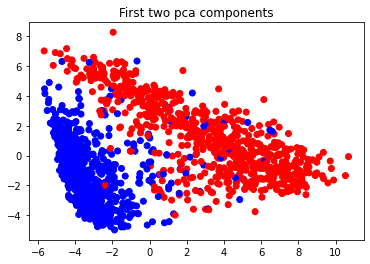

In [30]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_first_norm.iloc[:,1:])
plt.figure()
plt.scatter(X_pca[:,0],X_pca[:, 1], c=train_first_norm.label.map(colour))
plt.title("First two pca components")

plt.show()

Jak lze vidět, dvě komponenty stačí decentní oddělení dvou predikovaných příznaků.

In [31]:
from sklearn.decomposition import PCA

svm_pca = Pipeline([('pca', PCA()),('svc', SVC())])
gauss_pca = Pipeline([('pca', PCA()), ('gauss', GaussianNB())])
lda_pca = Pipeline([('pca', PCA()), ('lda', LinearDiscriminantAnalysis())])

pca_params = [1, 2, 3, 4, 5, 10, 15, 30]

svm_pca_params = {
    'svc__kernel':['rbf'], 'svc__C':list(np.arange(0.1, 10, 0.5)),
    'pca__n_components': pca_params
}
gauss_pca_params = {'gauss__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2],
                    'pca__n_components': pca_params}
lda_pca_params = {'lda__store_covariance': [True, False],
                  'lda__tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
                  'pca__n_components': pca_params}

grid_svm_pca = train_grid(train_first, svm_pca, svm_pca_params)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.867 total time=   0.1s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.904 total time=   0.2s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.926 total time=   0.1s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.874 total time=   0.1s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.819 total time=   0.1s
[CV 1/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.870 total time=   0.1s
[CV 2/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.904 total time=   0.1s
[CV 3/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.922 total time=   0.2s
[CV 4/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.889 total time=   0.1s
[CV 5/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.822 total 

[CV 2/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.904 total time=   0.2s
[CV 3/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.919 total time=   0.1s
[CV 4/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.874 total time=   0.1s
[CV 5/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.819 total time=   0.1s
[CV 1/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.870 total time=   0.1s
[CV 2/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.904 total time=   0.2s
[CV 3/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.919 total time=   0.2s
[CV 4/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.874 total time=   0.1s
[CV 5/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.819 total time=   0.1s
[CV 1/5] END pca__n_components=1, svc__C=9.6, svc__kernel=rbf;, score=0.870 total time=   0.2s
[CV 2/5] END pca__n_components=1, svc__C=9.6, svc_

[CV 4/5] END pca__n_components=2, svc__C=7.1, svc__kernel=rbf;, score=0.956 total time=   0.0s
[CV 5/5] END pca__n_components=2, svc__C=7.1, svc__kernel=rbf;, score=0.919 total time=   0.0s
[CV 1/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.944 total time=   0.0s
[CV 2/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.956 total time=   0.0s
[CV 3/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.963 total time=   0.0s
[CV 4/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.956 total time=   0.0s
[CV 5/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.919 total time=   0.0s
[CV 1/5] END pca__n_components=2, svc__C=8.1, svc__kernel=rbf;, score=0.944 total time=   0.0s
[CV 2/5] END pca__n_components=2, svc__C=8.1, svc__kernel=rbf;, score=0.959 total time=   0.0s
[CV 3/5] END pca__n_components=2, svc__C=8.1, svc__kernel=rbf;, score=0.963 total time=   0.0s
[CV 4/5] END pca__n_components=2, svc__C=8.1, svc_

[CV 1/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 2/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.978 total time=   0.0s
[CV 3/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.974 total time=   0.0s
[CV 1/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.978 total time=   0.0s
[CV 2/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.978 total time=   0.0s
[CV 3/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.985 total time=   0.0s
[CV 4/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.989 total time=   0.0s
[CV 5/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.974 total time=   0.0s
[CV 1/5] END pca__n_components=3, svc__C=7.1, svc_

[CV 3/5] END pca__n_components=4, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END pca__n_components=4, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.0s
[CV 5/5] END pca__n_components=4, svc__C=4.6, svc__kernel=rbf;, score=0.974 total time=   0.0s
[CV 1/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.978 total time=   0.0s
[CV 2/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.974 total time=   0.0s
[CV 3/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.970 total time=   0.2s
[CV 1/5] END pca__n_components=4, svc__C=5.6, svc__kernel=rbf;, score=0.974 total time=   0.1s
[CV 2/5] END pca__n_components=4, svc__C=5.6, svc__kernel=rbf;, score=0.974 total time=   0.0s
[CV 3/5] END pca__n_components=4, svc__C=5.6, svc_

[CV 5/5] END pca__n_components=5, svc__C=3.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 1/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.974 total time=   0.0s
[CV 2/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 3/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 1/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.974 total time=   0.1s
[CV 2/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.978 total time=   0.0s
[CV 3/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=5, svc__C=4.1, svc_

[CV 2/5] END pca__n_components=10, svc__C=2.1, svc__kernel=rbf;, score=0.981 total time=   0.1s
[CV 3/5] END pca__n_components=10, svc__C=2.1, svc__kernel=rbf;, score=0.993 total time=   0.1s
[CV 4/5] END pca__n_components=10, svc__C=2.1, svc__kernel=rbf;, score=0.981 total time=   0.1s
[CV 5/5] END pca__n_components=10, svc__C=2.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 1/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 2/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.981 total time=   0.1s
[CV 3/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.993 total time=   0.1s
[CV 4/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 5/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 1/5] END pca__n_components=10, svc__C=3.1, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 2/5] END pca__n_components=10, svc__

[CV 3/5] END pca__n_components=15, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END pca__n_components=15, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=15, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 1/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.981 total time=   0.1s
[CV 2/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 3/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 4/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 1/5] END pca__n_components=15, svc__C=1.6, svc__kernel=rbf;, score=0.981 total time=   0.2s
[CV 2/5] END pca__n_components=15, svc__C=1.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 3/5] END pca__n_components=15, svc__

[CV 5/5] END pca__n_components=15, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 1/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 2/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 3/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.993 total time=   0.1s
[CV 4/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.981 total time=   0.1s
[CV 1/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.970 total time=   1.4s
[CV 2/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.970 total time=   1.4s
[CV 3/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.985 total time=   1.5s
[CV 4/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.974 total time=   1.5s
[CV 5/5] END pca__n_components=30, svc__

[CV 2/5] END pca__n_components=30, svc__C=8.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 3/5] END pca__n_components=30, svc__C=8.1, svc__kernel=rbf;, score=0.993 total time=   0.2s
[CV 4/5] END pca__n_components=30, svc__C=8.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=30, svc__C=8.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 1/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 3/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.993 total time=   0.1s
[CV 4/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 1/5] END pca__n_components=30, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=30, svc__

In [32]:
grid_svm_pca_norm = train_grid(train_first_norm, svm_pca, svm_pca_params)

Fitting 5 folds for each of 160 candidates, totalling 800 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.881 total time=   1.7s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.878 total time=   0.1s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.859 total time=   0.1s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.878 total time=   0.2s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__kernel=rbf;, score=0.841 total time=   0.1s
[CV 1/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.878 total time=   0.1s
[CV 2/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.878 total time=   0.1s
[CV 3/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.859 total time=   0.1s
[CV 4/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.881 total time=   0.1s
[CV 5/5] END pca__n_components=1, svc__C=0.6, svc__kernel=rbf;, score=0.848 total 

[CV 2/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.878 total time=   0.1s
[CV 3/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.859 total time=   0.2s
[CV 4/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.881 total time=   0.1s
[CV 5/5] END pca__n_components=1, svc__C=8.6, svc__kernel=rbf;, score=0.848 total time=   0.1s
[CV 1/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.878 total time=   0.2s
[CV 2/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.878 total time=   0.2s
[CV 3/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.859 total time=   0.3s
[CV 4/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.885 total time=   0.2s
[CV 5/5] END pca__n_components=1, svc__C=9.1, svc__kernel=rbf;, score=0.848 total time=   0.2s
[CV 1/5] END pca__n_components=1, svc__C=9.6, svc__kernel=rbf;, score=0.878 total time=   0.1s
[CV 2/5] END pca__n_components=1, svc__C=9.6, svc_

[CV 4/5] END pca__n_components=2, svc__C=7.1, svc__kernel=rbf;, score=0.944 total time=   0.0s
[CV 5/5] END pca__n_components=2, svc__C=7.1, svc__kernel=rbf;, score=0.944 total time=   0.0s
[CV 1/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.970 total time=   0.1s
[CV 2/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.956 total time=   0.0s
[CV 3/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.956 total time=   0.1s
[CV 4/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.944 total time=   0.0s
[CV 5/5] END pca__n_components=2, svc__C=7.6, svc__kernel=rbf;, score=0.944 total time=   0.0s
[CV 1/5] END pca__n_components=2, svc__C=8.1, svc__kernel=rbf;, score=0.970 total time=   0.0s
[CV 2/5] END pca__n_components=2, svc__C=8.1, svc__kernel=rbf;, score=0.956 total time=   0.0s
[CV 3/5] END pca__n_components=2, svc__C=8.1, svc__kernel=rbf;, score=0.956 total time=   0.0s
[CV 4/5] END pca__n_components=2, svc__C=8.1, svc_

[CV 2/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.978 total time=   0.0s
[CV 3/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 4/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.989 total time=   0.2s
[CV 5/5] END pca__n_components=3, svc__C=6.1, svc__kernel=rbf;, score=0.963 total time=   0.1s
[CV 1/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.985 total time=   0.0s
[CV 2/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.978 total time=   0.0s
[CV 3/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.989 total time=   0.0s
[CV 4/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=3, svc__C=6.6, svc__kernel=rbf;, score=0.963 total time=   0.1s
[CV 1/5] END pca__n_components=3, svc__C=7.1, svc__kernel=rbf;, score=0.985 total time=   0.0s
[CV 2/5] END pca__n_components=3, svc__C=7.1, svc_

[CV 4/5] END pca__n_components=4, svc__C=4.6, svc__kernel=rbf;, score=0.981 total time=   0.1s
[CV 5/5] END pca__n_components=4, svc__C=4.6, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 1/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.981 total time=   0.0s
[CV 3/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.981 total time=   0.0s
[CV 5/5] END pca__n_components=4, svc__C=5.1, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 1/5] END pca__n_components=4, svc__C=5.6, svc__kernel=rbf;, score=0.985 total time=   0.0s
[CV 2/5] END pca__n_components=4, svc__C=5.6, svc__kernel=rbf;, score=0.981 total time=   0.0s
[CV 3/5] END pca__n_components=4, svc__C=5.6, svc__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/5] END pca__n_components=4, svc__C=5.6, svc_

[CV 2/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 3/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=5, svc__C=3.6, svc__kernel=rbf;, score=0.974 total time=   0.0s
[CV 1/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 3/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=5, svc__C=4.1, svc__kernel=rbf;, score=0.974 total time=   0.1s
[CV 1/5] END pca__n_components=5, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=5, svc__C=4.6, svc_

[CV 4/5] END pca__n_components=10, svc__C=2.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=10, svc__C=2.1, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 1/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 3/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.989 total time=   0.0s
[CV 5/5] END pca__n_components=10, svc__C=2.6, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 1/5] END pca__n_components=10, svc__C=3.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=10, svc__C=3.1, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 3/5] END pca__n_components=10, svc__C=3.1, svc__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/5] END pca__n_components=10, svc__

[CV 5/5] END pca__n_components=15, svc__C=0.6, svc__kernel=rbf;, score=0.970 total time=   0.1s
[CV 1/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.985 total time=   0.0s
[CV 2/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 3/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=15, svc__C=1.1, svc__kernel=rbf;, score=0.970 total time=   0.1s
[CV 1/5] END pca__n_components=15, svc__C=1.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=15, svc__C=1.6, svc__kernel=rbf;, score=0.981 total time=   0.1s
[CV 3/5] END pca__n_components=15, svc__C=1.6, svc__kernel=rbf;, score=1.000 total time=   0.1s
[CV 4/5] END pca__n_components=15, svc__C=1.6, svc__kernel=rbf;, score=0.989 total time=   0.1s
[CV 5/5] END pca__n_components=15, svc__

[CV 2/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 3/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.996 total time=   0.1s
[CV 4/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=15, svc__C=9.6, svc__kernel=rbf;, score=0.989 total time=   0.0s
[CV 1/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.978 total time=   0.1s
[CV 2/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.974 total time=   0.2s
[CV 3/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.989 total time=   0.2s
[CV 4/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 5/5] END pca__n_components=30, svc__C=0.1, svc__kernel=rbf;, score=0.967 total time=   0.1s
[CV 1/5] END pca__n_components=30, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.1s
[CV 2/5] END pca__n_components=30, svc__

[CV 3/5] END pca__n_components=30, svc__C=8.1, svc__kernel=rbf;, score=0.996 total time=   0.2s
[CV 4/5] END pca__n_components=30, svc__C=8.1, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 5/5] END pca__n_components=30, svc__C=8.1, svc__kernel=rbf;, score=0.981 total time=   0.2s
[CV 1/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.985 total time=   0.2s
[CV 2/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.985 total time=   0.2s
[CV 3/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.996 total time=   0.2s
[CV 4/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.985 total time=   0.2s
[CV 5/5] END pca__n_components=30, svc__C=8.6, svc__kernel=rbf;, score=0.981 total time=   0.2s
[CV 1/5] END pca__n_components=30, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.2s
[CV 2/5] END pca__n_components=30, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.2s
[CV 3/5] END pca__n_components=30, svc__

In [33]:

grid_gauss_pca = train_grid(train_first, gauss_pca, gauss_pca_params)

Fitting 5 folds for each of 104 candidates, totalling 520 fits
[CV 1/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.844 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.911 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.915 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.859 total time=   0.1s
[CV 5/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.811 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.937 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.967 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.959 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.956 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.907 total time=   0.

[CV 4/5] END gauss__var_smoothing=1e-09, pca__n_components=2;, score=0.956 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-09, pca__n_components=2;, score=0.907 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.970 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.981 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.970 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.985 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.967 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-09, pca__n_components=4;, score=0.948 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-09, pca__n_components=4;, score=0.978 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-09, pca__n_components=4;, score=0.978 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-09, pca__n_components=4

[CV 1/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.948 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.978 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.978 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.978 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.959 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.967 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.978 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.967 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.978 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.963 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-07, pca__n_components=1

[CV 4/5] END gauss__var_smoothing=1e-05, pca__n_components=5;, score=0.978 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-05, pca__n_components=5;, score=0.963 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.967 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.981 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.970 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.981 total time=   0.1s
[CV 5/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.944 total time=   0.1s
[CV 1/5] END gauss__var_smoothing=1e-05, pca__n_components=15;, score=0.967 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=1e-05, pca__n_components=15;, score=0.978 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-05, pca__n_components=15;, score=0.974 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-05, pca__n_comp

[CV 1/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.967 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.981 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.974 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.978 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.959 total time=   0.1s
[CV 1/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.967 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.967 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.963 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 5/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.948 total time=   0.2s
[CV 1/5] END gauss__var_smoothing=0.01, pca__n_com

[CV 4/5] END gauss__var_smoothing=0.1, pca__n_components=30;, score=0.967 total time=   0.2s
[CV 5/5] END gauss__var_smoothing=0.1, pca__n_components=30;, score=0.907 total time=   0.1s
[CV 1/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.774 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.848 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.852 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.837 total time=   0.1s
[CV 5/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.770 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.793 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.870 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.856 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.

In [34]:
grid_gauss_pca_norm = train_grid(train_first_norm, gauss_pca, gauss_pca_params)

Fitting 5 folds for each of 104 candidates, totalling 520 fits
[CV 1/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.874 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.870 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.859 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.878 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-11, pca__n_components=1;, score=0.830 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.959 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.952 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.963 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.941 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-11, pca__n_components=2;, score=0.944 total time=   0.

[CV 3/5] END gauss__var_smoothing=1e-09, pca__n_components=2;, score=0.963 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-09, pca__n_components=2;, score=0.941 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-09, pca__n_components=2;, score=0.944 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.981 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.974 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.989 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.978 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-09, pca__n_components=3;, score=0.970 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-09, pca__n_components=4;, score=0.978 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-09, pca__n_components=4;, score=0.970 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-09, pca__n_components=4

[CV 5/5] END gauss__var_smoothing=1e-07, pca__n_components=3;, score=0.970 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.978 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.970 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.989 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.974 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-07, pca__n_components=4;, score=0.970 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.970 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.970 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.989 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=1e-07, pca__n_components=5;, score=0.970 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-07, pca__n_components=5

[CV 3/5] END gauss__var_smoothing=1e-05, pca__n_components=5;, score=0.989 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=1e-05, pca__n_components=5;, score=0.970 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=1e-05, pca__n_components=5;, score=0.970 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.981 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.978 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.981 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.985 total time=   0.1s
[CV 5/5] END gauss__var_smoothing=1e-05, pca__n_components=10;, score=0.956 total time=   0.1s
[CV 1/5] END gauss__var_smoothing=1e-05, pca__n_components=15;, score=0.981 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=1e-05, pca__n_components=15;, score=0.970 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=1e-05, pca__n_compo

[CV 5/5] END gauss__var_smoothing=0.001, pca__n_components=10;, score=0.963 total time=   0.1s
[CV 1/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.981 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.970 total time=   0.0s
[CV 3/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.985 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.978 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=0.001, pca__n_components=15;, score=0.970 total time=   0.0s
[CV 1/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.981 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.974 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.978 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=0.001, pca__n_components=30;, score=0.970 total time=   0.1s
[CV 5/5] END gauss__var_smoothing=0.001, pca__n_co

[CV 4/5] END gauss__var_smoothing=0.1, pca__n_components=30;, score=0.963 total time=   0.1s
[CV 5/5] END gauss__var_smoothing=0.1, pca__n_components=30;, score=0.930 total time=   0.1s
[CV 1/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.841 total time=   0.1s
[CV 2/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.837 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.830 total time=   0.1s
[CV 4/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.852 total time=   0.0s
[CV 5/5] END gauss__var_smoothing=10.0, pca__n_components=1;, score=0.796 total time=   0.1s
[CV 1/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.874 total time=   0.0s
[CV 2/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.889 total time=   0.1s
[CV 3/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.874 total time=   0.0s
[CV 4/5] END gauss__var_smoothing=10.0, pca__n_components=2;, score=0.

In [35]:

grid_lda_pca = train_grid(train_first, lda_pca, lda_pca_params)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.848 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.896 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.915 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.863 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.815 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=2;, score=0.930 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=2;, score=0.963 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=2;, score=0.948 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, 

[CV 1/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.981 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.978 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.981 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.989 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.848 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.896 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.915 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.863 total time=   0.1s
[CV 5

[CV 5/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=10;, score=0.963 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.970 total time=   0.0s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.974 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.978 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.993 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.978 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=30;, score=0.981 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=30;, score=0.981 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=30;, score=0.981 total time=

[CV 1/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.967 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.974 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.978 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.985 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.963 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.970 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.974 total time=   0.0s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.978 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.993 total time=   0.1s
[CV 5/5] E

[CV 3/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=5;, score=0.511 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=5;, score=0.511 total time=   0.0s
[CV 5/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=5;, score=0.511 total time=   0.0s
[CV 1/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.507 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.507 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.511 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.511 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.511 total time=   0.0s
[CV 1/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=15;, score=0.507 total time=   0.1s
[CV 2/5] END lda__stor

[CV 3/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=4;, score=0.948 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=4;, score=0.967 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=4;, score=0.930 total time=   0.1s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.948 total time=   0.1s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.967 total time=   0.1s
[CV 3/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.974 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.970 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.937 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=10;, score=0.967 total time=   0.1s


[CV 3/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=3;, score=0.941 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=3;, score=0.967 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=3;, score=0.926 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.937 total time=   0.0s
[CV 2/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.963 total time=   0.0s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.948 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.967 total time=   0.1s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.930 total time=   0.1s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=5;, score=0.948 total time=

[CV 3/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=2;, score=0.948 total time=   0.1s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=2;, score=0.963 total time=   0.1s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=2;, score=0.926 total time=   0.1s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.922 total time=   0.1s
[CV 2/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.970 total time=   0.2s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.941 total time=   0.2s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.967 total time=   0.1s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.926 total time=   0.1s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=4;, score=0.937 total time=   0.1s
[CV 2/5] E

[CV 4/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=1;, score=0.511 total time=   0.1s
[CV 5/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=1;, score=0.511 total time=   0.1s
[CV 1/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.507 total time=   0.0s
[CV 2/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.507 total time=   0.1s
[CV 3/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.511 total time=   0.1s
[CV 4/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.511 total time=   0.1s
[CV 5/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.511 total time=   0.1s
[CV 1/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=3;, score=0.507 total time=   0.1s
[CV 2/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=3;, score=0.507 total time=   0.1s
[CV 3/5] END lda__s

In [36]:
grid_lda_pca_norm = train_grid(train_first_norm, lda_pca, lda_pca_params)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.856 total time=   0.2s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.870 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.863 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.878 total time=   0.0s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=1;, score=0.822 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=2;, score=0.963 total time=   0.0s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=2;, score=0.967 total time=   0.2s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, pca__n_components=2;, score=0.952 total time=   0.4s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, 

[CV 1/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.989 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-06, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.856 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.870 total time=   0.0s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.863 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-05, pca__n_components=1;, score=0.878 total time=   0.1s
[CV 5

[CV 5/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=10;, score=0.970 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.974 total time=   0.0s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.970 total time=   0.0s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.985 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.981 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=15;, score=0.967 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=30;, score=0.985 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.0001, pca__n_components=30;, score=0.985 total time=

[CV 1/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.974 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.963 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.981 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.985 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=10;, score=0.970 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.974 total time=   0.1s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.970 total time=   0.1s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.981 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.01, pca__n_components=15;, score=0.981 total time=   0.1s
[CV 5/5] E

[CV 3/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=5;, score=0.504 total time=   0.0s
[CV 4/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=5;, score=0.504 total time=   0.0s
[CV 5/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=5;, score=0.504 total time=   0.0s
[CV 1/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.500 total time=   0.0s
[CV 2/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.500 total time=   0.0s
[CV 3/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.504 total time=   0.1s
[CV 4/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.504 total time=   0.1s
[CV 5/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=10;, score=0.504 total time=   0.1s
[CV 1/5] END lda__store_covariance=True, lda__tol=1.0, pca__n_components=15;, score=0.500 total time=   0.1s
[CV 2/5] END lda__stor

[CV 4/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=4;, score=0.963 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=4;, score=0.956 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.970 total time=   0.1s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.967 total time=   0.1s
[CV 3/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.974 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.967 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=5;, score=0.959 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=10;, score=0.974 total time=   0.1s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-06, pca__n_components=10;, score=0.963 total time=   0.1s

[CV 4/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=3;, score=0.941 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=3;, score=0.937 total time=   0.1s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.970 total time=   0.1s
[CV 2/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.963 total time=   0.1s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.974 total time=   0.1s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.963 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=4;, score=0.956 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=5;, score=0.970 total time=   0.0s
[CV 2/5] END lda__store_covariance=False, lda__tol=0.0001, pca__n_components=5;, score=0.967 total time=

[CV 3/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=2;, score=0.952 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=2;, score=0.944 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=2;, score=0.937 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.970 total time=   0.1s
[CV 2/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.967 total time=   0.0s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.952 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.941 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=3;, score=0.937 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.01, pca__n_components=4;, score=0.970 total time=   0.0s
[CV 2/5] E

[CV 4/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=1;, score=0.504 total time=   0.1s
[CV 5/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=1;, score=0.504 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.500 total time=   0.0s
[CV 2/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.500 total time=   0.0s
[CV 3/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.504 total time=   0.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.504 total time=   0.0s
[CV 5/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=2;, score=0.504 total time=   0.0s
[CV 1/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=3;, score=0.500 total time=   0.0s
[CV 2/5] END lda__store_covariance=False, lda__tol=1.0, pca__n_components=3;, score=0.500 total time=   0.0s
[CV 3/5] END lda__s

Všechny metody již pri použití jedné hlavní komponenty dosahují přesnosti přesahující 85 % a přidání druhé stačí ke zvýšení přesnosti nad 90 %.

Dále budem testovat rychlosti trénování v závislosti na počtu použitých komponent

In [64]:
from datetime import datetime
pca_speed_testing = [1, 5, 10, 20, 40, 80, 120, 200]
svm1_list = []
svm2_list = []
gauss_list = []
lda_list = []
for n_comp in pca_speed_testing:
    pca = PCA(n_comp)
    X = pca.fit_transform(train_first.iloc[:,1:])
    y = train_first.label
    print(f"Components: {n_comp}")
    t1 = datetime.now()
    svm1 = SVC(kernel='rbf')
    svm1.fit(X, y)
    t2 = datetime.now()
    print(f"RBF time: {t2-t1}")
    svm1_list.append(t2-t1)
    svm2 = SVC(kernel='linear')
    svm2.fit(X, y)
    t3 = datetime.now()
    print(f"Linear time: {t3-t2}")
    svm2_list.append(t3-t2)
    gauss = GaussianNB()
    gauss.fit(X, y)
    t4 = datetime.now()
    print(f"Gaussian NB time: {t4-t3}")
    gauss_list.append(t4-t3)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    t5 = datetime.now()
    print(f"LDA time: {t5-t4}")
    lda_list.append(t5-t4)

    
    


Components: 1
RBF time: 0:00:00.043997
Linear time: 0:04:16.105544
Gaussian NB time: 0:00:00.002001
LDA time: 0:00:00.001000
Components: 5
RBF time: 0:00:00.020004
Linear time: 0:01:06.933478
Gaussian NB time: 0:00:00.001006
LDA time: 0:00:00.003994
Components: 10
RBF time: 0:00:00.016992
Linear time: 0:02:22.970507
Gaussian NB time: 0:00:00.003004
LDA time: 0:00:00.005000
Components: 20
RBF time: 0:00:00.033008
Linear time: 0:04:12.324145
Gaussian NB time: 0:00:00.002003
LDA time: 0:00:00.006561
Components: 40
RBF time: 0:00:00.021996
Linear time: 0:03:50.793624
Gaussian NB time: 0:00:00.002005
LDA time: 0:00:00.008997
Components: 80
RBF time: 0:00:00.028989
Linear time: 0:00:00.034001
Gaussian NB time: 0:00:00.003007
LDA time: 0:00:00.027992
Components: 120
RBF time: 0:00:00.039995
Linear time: 0:00:00.024999
Gaussian NB time: 0:00:00.003001
LDA time: 0:00:00.035016
Components: 200
RBF time: 0:00:00.048999
Linear time: 0:00:00.025000
Gaussian NB time: 0:00:00.005005
LDA time: 0:00:00

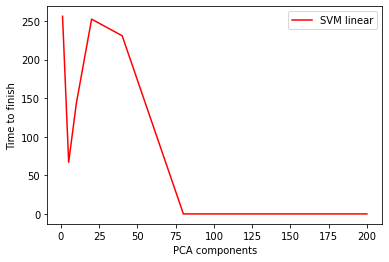

In [74]:
fig, ax = plt.subplots()

ax.plot(pca_speed_testing, [x.total_seconds() for x in svm2_list], color='red', label='SVM linear')
ax.set_xlabel("PCA components")
ax.set_ylabel("Time to finish")
ax.legend()
plt.show()

Jak lze vidět, nízké množství dimenzí silně zhoršuje výkonnost SVC s linearním kernelem.

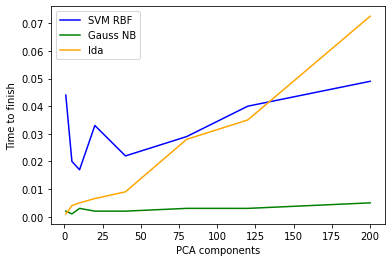

In [73]:
fig, ax = plt.subplots()

ax.plot(pca_speed_testing, [x.total_seconds() for x in svm1_list], color='blue', label='SVM RBF')
ax.plot(pca_speed_testing, [x.total_seconds() for x in gauss_list], color='green', label='Gauss NB')
ax.plot(pca_speed_testing, [x.total_seconds() for x in lda_list], color='orange', label='lda')
ax.set_xlabel("PCA components")
ax.set_ylabel("Time to finish")
ax.legend()
plt.show()

Nejvíce ze sniženého množství dimenzí profituje lda, Gaussovský NB je množstvím dimenzí ovlivněn pouze slabě a SVC s rbf jádrem má nejvýkonnější množství dimenzí kolem cca 10.

In [75]:
from sklearn.manifold import LocallyLinearEmbedding


Nejdříve otestujeme rychlost s LLE

In [77]:
lle_speed_testing = [1, 5, 10, 20, 40, 80, 120, 200]
svm1_list = []
svm2_list = []
gauss_list = []
lda_list = []
for n_comp in lle_speed_testing:
    lle = LocallyLinearEmbedding(n_components=n_comp)
    X = lle.fit_transform(train_first.iloc[:,1:])
    y = train_first.label
    print(f"Components: {n_comp}")
    t1 = datetime.now()
    svm1 = SVC(kernel='rbf')
    svm1.fit(X, y)
    t2 = datetime.now()
    print(f"RBF time: {t2-t1}")
    svm1_list.append(t2-t1)
    svm2 = SVC(kernel='linear')
    svm2.fit(X, y)
    t3 = datetime.now()
    print(f"Linear time: {t3-t2}")
    svm2_list.append(t3-t2)
    gauss = GaussianNB()
    gauss.fit(X, y)
    t4 = datetime.now()
    print(f"Gaussian NB time: {t4-t3}")
    gauss_list.append(t4-t3)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    t5 = datetime.now()
    print(f"LDA time: {t5-t4}")
    lda_list.append(t5-t4)

Components: 1
RBF time: 0:00:00.013999
Linear time: 0:00:00.062002
Gaussian NB time: 0:00:00.001001
LDA time: 0:00:00.002004
Components: 5
RBF time: 0:00:00.010999
Linear time: 0:00:00.066000
Gaussian NB time: 0:00:00.002006
LDA time: 0:00:00.001999
Components: 10
RBF time: 0:00:00.014000
Linear time: 0:00:00.062999
Gaussian NB time: 0:00:00.002001
LDA time: 0:00:00.002999
Components: 20
RBF time: 0:00:00.030999
Linear time: 0:00:00.098001
Gaussian NB time: 0:00:00.002005
LDA time: 0:00:00.008000
Components: 40
RBF time: 0:00:00.041001
Linear time: 0:00:00.092000
Gaussian NB time: 0:00:00.002000
LDA time: 0:00:00.010004
Components: 80
RBF time: 0:00:00.094012
Linear time: 0:00:00.129998
Gaussian NB time: 0:00:00.005001
LDA time: 0:00:00.025000
Components: 120
RBF time: 0:00:00.303566
Linear time: 0:00:00.196599
Gaussian NB time: 0:00:00.006998
LDA time: 0:00:00.042245
Components: 200
RBF time: 0:00:00.549623
Linear time: 0:00:00.211765
Gaussian NB time: 0:00:00.008991
LDA time: 0:00:00

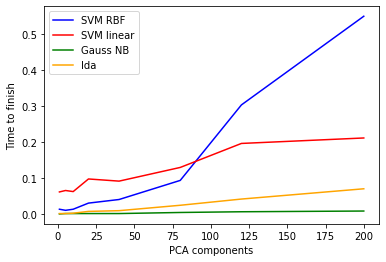

In [79]:
fig, ax = plt.subplots()

ax.plot(pca_speed_testing, [x.total_seconds() for x in svm1_list], color='blue', label='SVM RBF')
ax.plot(pca_speed_testing, [x.total_seconds() for x in svm2_list], color='red', label='SVM linear')

ax.plot(pca_speed_testing, [x.total_seconds() for x in gauss_list], color='green', label='Gauss NB')
ax.plot(pca_speed_testing, [x.total_seconds() for x in lda_list], color='orange', label='lda')
ax.set_xlabel("PCA components")
ax.set_ylabel("Time to finish")
ax.legend()
plt.show()

S lle, v nižších dimenzích se SVM s rbf jádrem trénuje rychleji, než s PCA, tato výhoda se ovšem rychle ztrácí v dimenzích vyšších.
SVM s lineárním kernelem, se trénuje mnohem rychleji než s PCA a narozdíl od PCA, snižení dimenzí zde vytváří menší dobu trénování.
Gaussovský NB a LDA se chovájí podobně jako s PCA.

Obecně zde doba trénování modelů je přímo uměrná s počtem dimenzí.

In [80]:

svm_lle = Pipeline([('lle', LocallyLinearEmbedding()),('svc', SVC())])
gauss_lle = Pipeline([('lle', LocallyLinearEmbedding()), ('gauss', GaussianNB())])
lda_lle = Pipeline([('lle', LocallyLinearEmbedding()), ('lda', LinearDiscriminantAnalysis())])

lle_params = [2, 4, 5, 10, 15, 30, 60]

svm_lle_params = {
    'svc__kernel':['rbf'], 'svc__C':list(np.arange(0.1, 10, 0.5)),
    'lle__n_components': lle_params
}
gauss_lle_params = {'gauss__var_smoothing': [1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e1, 1e2],
                    'lle__n_components': lle_params}
lda_lle_params = {'lda__store_covariance': [True, False],
                  'lda__tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
                  'lle__n_components': lle_params}

In [81]:
grid_svm_lle = train_grid(train_first, svm_lle, svm_lle_params)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV 1/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.967 total time=   0.3s
[CV 2/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.978 total time=   0.3s
[CV 3/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 4/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.974 total time=   0.3s
[CV 5/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.967 total time=   0.3s
[CV 1/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.967 total time=   0.3s
[CV 2/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.981 total time=   0.3s
[CV 3/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 4/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.974 total time=   0.4s
[CV 5/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.970 total 

[CV 2/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.978 total time=   0.4s
[CV 3/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 4/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.974 total time=   0.5s
[CV 5/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.974 total time=   0.4s
[CV 1/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.974 total time=   0.3s
[CV 2/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.978 total time=   0.3s
[CV 3/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 4/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.974 total time=   0.4s
[CV 5/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.974 total time=   0.4s
[CV 1/5] END lle__n_components=2, svc__C=9.6, svc__kernel=rbf;, score=0.970 total time=   0.4s
[CV 2/5] END lle__n_components=2, svc__C=9.6, svc_

[CV 4/5] END lle__n_components=4, svc__C=7.1, svc__kernel=rbf;, score=0.981 total time=   0.4s
[CV 5/5] END lle__n_components=4, svc__C=7.1, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 1/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.970 total time=   0.3s
[CV 2/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.981 total time=   0.3s
[CV 3/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 4/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.981 total time=   0.3s
[CV 5/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.981 total time=   0.3s
[CV 1/5] END lle__n_components=4, svc__C=8.1, svc__kernel=rbf;, score=0.974 total time=   0.3s
[CV 2/5] END lle__n_components=4, svc__C=8.1, svc__kernel=rbf;, score=0.981 total time=   0.4s
[CV 3/5] END lle__n_components=4, svc__C=8.1, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 4/5] END lle__n_components=4, svc__C=8.1, svc_

[CV 1/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.974 total time=   0.3s
[CV 2/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.981 total time=   0.5s
[CV 3/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 4/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.981 total time=   0.4s
[CV 5/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.981 total time=   0.4s
[CV 1/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.978 total time=   0.4s
[CV 2/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.981 total time=   0.4s
[CV 3/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 4/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.981 total time=   0.3s
[CV 5/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.981 total time=   0.4s
[CV 1/5] END lle__n_components=5, svc__C=7.1, svc_

[CV 2/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 3/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 4/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 5/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 1/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.974 total time=   0.7s
[CV 2/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 3/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 4/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 5/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 1/5] END lle__n_components=10, svc__C=5.6, svc__kernel=rbf;, score=0.974 total time=   0.6s
[CV 2/5] END lle__n_components=10, svc__

[CV 3/5] END lle__n_components=15, svc__C=3.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 4/5] END lle__n_components=15, svc__C=3.1, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 5/5] END lle__n_components=15, svc__C=3.1, svc__kernel=rbf;, score=0.985 total time=   0.5s
[CV 1/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.974 total time=   0.6s
[CV 2/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 3/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 4/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 5/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 1/5] END lle__n_components=15, svc__C=4.1, svc__kernel=rbf;, score=0.974 total time=   0.6s
[CV 2/5] END lle__n_components=15, svc__C=4.1, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 3/5] END lle__n_components=15, svc__

[CV 4/5] END lle__n_components=30, svc__C=1.6, svc__kernel=rbf;, score=0.981 total time=   0.7s
[CV 5/5] END lle__n_components=30, svc__C=1.6, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 1/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 2/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 3/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 4/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.981 total time=   0.7s
[CV 5/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.989 total time=   0.8s
[CV 1/5] END lle__n_components=30, svc__C=2.6, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 2/5] END lle__n_components=30, svc__C=2.6, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 3/5] END lle__n_components=30, svc__C=2.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 4/5] END lle__n_components=30, svc__

[CV 5/5] END lle__n_components=60, svc__C=0.1, svc__kernel=rbf;, score=0.985 total time=   1.2s
[CV 1/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.981 total time=   0.9s
[CV 2/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 3/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 4/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 5/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 1/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.981 total time=   0.8s
[CV 2/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 3/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 4/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 5/5] END lle__n_components=60, svc__

[CV 1/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.974 total time=   0.7s
[CV 2/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 3/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 4/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.981 total time=   0.7s
[CV 5/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.8s
[CV 1/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.974 total time=   0.7s
[CV 2/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 3/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 4/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 5/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.7s


0.9851851851851852
{'lle__n_components

In [82]:
grid_svm_lle_norm = train_grid(train_first_norm, svm_lle, svm_lle_params)

Fitting 5 folds for each of 140 candidates, totalling 700 fits
[CV 1/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 2/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.981 total time=   0.4s
[CV 3/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.989 total time=   0.3s
[CV 4/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.978 total time=   0.3s
[CV 5/5] END lle__n_components=2, svc__C=0.1, svc__kernel=rbf;, score=0.974 total time=   0.3s
[CV 1/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 2/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 3/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.989 total time=   0.3s
[CV 4/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.974 total time=   0.3s
[CV 5/5] END lle__n_components=2, svc__C=0.6, svc__kernel=rbf;, score=0.974 total 

[CV 2/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 3/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.989 total time=   0.5s
[CV 4/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.978 total time=   0.4s
[CV 5/5] END lle__n_components=2, svc__C=8.6, svc__kernel=rbf;, score=0.974 total time=   0.5s
[CV 1/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 2/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.989 total time=   0.3s
[CV 3/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.989 total time=   0.3s
[CV 4/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.967 total time=   0.3s
[CV 5/5] END lle__n_components=2, svc__C=9.1, svc__kernel=rbf;, score=0.974 total time=   0.3s
[CV 1/5] END lle__n_components=2, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 2/5] END lle__n_components=2, svc__C=9.6, svc_

[CV 4/5] END lle__n_components=4, svc__C=7.1, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 5/5] END lle__n_components=4, svc__C=7.1, svc__kernel=rbf;, score=0.978 total time=   0.4s
[CV 1/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.978 total time=   0.4s
[CV 2/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.989 total time=   0.3s
[CV 3/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.993 total time=   0.3s
[CV 4/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.974 total time=   0.4s
[CV 5/5] END lle__n_components=4, svc__C=7.6, svc__kernel=rbf;, score=0.978 total time=   0.4s
[CV 1/5] END lle__n_components=4, svc__C=8.1, svc__kernel=rbf;, score=0.974 total time=   0.4s
[CV 2/5] END lle__n_components=4, svc__C=8.1, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 3/5] END lle__n_components=4, svc__C=8.1, svc__kernel=rbf;, score=0.993 total time=   0.4s
[CV 4/5] END lle__n_components=4, svc__C=8.1, svc_

[CV 1/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.974 total time=   0.4s
[CV 2/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 3/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.996 total time=   0.5s
[CV 4/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.970 total time=   0.4s
[CV 5/5] END lle__n_components=5, svc__C=6.1, svc__kernel=rbf;, score=0.985 total time=   0.4s
[CV 1/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.974 total time=   0.5s
[CV 2/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.985 total time=   0.3s
[CV 3/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.996 total time=   0.3s
[CV 4/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.978 total time=   0.4s
[CV 5/5] END lle__n_components=5, svc__C=6.6, svc__kernel=rbf;, score=0.981 total time=   0.3s
[CV 1/5] END lle__n_components=5, svc__C=7.1, svc_

[CV 2/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 3/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.996 total time=   0.8s
[CV 4/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 5/5] END lle__n_components=10, svc__C=4.6, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 1/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.978 total time=   0.6s
[CV 2/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 3/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.996 total time=   0.5s
[CV 4/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 5/5] END lle__n_components=10, svc__C=5.1, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 1/5] END lle__n_components=10, svc__C=5.6, svc__kernel=rbf;, score=0.978 total time=   0.5s
[CV 2/5] END lle__n_components=10, svc__

[CV 3/5] END lle__n_components=15, svc__C=3.1, svc__kernel=rbf;, score=0.996 total time=   0.6s
[CV 4/5] END lle__n_components=15, svc__C=3.1, svc__kernel=rbf;, score=0.993 total time=   0.7s
[CV 5/5] END lle__n_components=15, svc__C=3.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 1/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.974 total time=   0.6s
[CV 2/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 3/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.996 total time=   0.6s
[CV 4/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.993 total time=   0.8s
[CV 5/5] END lle__n_components=15, svc__C=3.6, svc__kernel=rbf;, score=0.985 total time=   0.5s
[CV 1/5] END lle__n_components=15, svc__C=4.1, svc__kernel=rbf;, score=0.970 total time=   0.6s
[CV 2/5] END lle__n_components=15, svc__C=4.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 3/5] END lle__n_components=15, svc__

[CV 4/5] END lle__n_components=30, svc__C=1.6, svc__kernel=rbf;, score=0.993 total time=   0.6s
[CV 5/5] END lle__n_components=30, svc__C=1.6, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 1/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.981 total time=   0.7s
[CV 2/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 3/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=1.000 total time=   0.6s
[CV 4/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.993 total time=   0.6s
[CV 5/5] END lle__n_components=30, svc__C=2.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 1/5] END lle__n_components=30, svc__C=2.6, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 2/5] END lle__n_components=30, svc__C=2.6, svc__kernel=rbf;, score=0.989 total time=   0.6s
[CV 3/5] END lle__n_components=30, svc__C=2.6, svc__kernel=rbf;, score=1.000 total time=   0.8s
[CV 4/5] END lle__n_components=30, svc__

[CV 5/5] END lle__n_components=60, svc__C=0.1, svc__kernel=rbf;, score=0.985 total time=   0.8s
[CV 1/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.981 total time=   0.7s
[CV 2/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 3/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.996 total time=   1.0s
[CV 4/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.993 total time=   0.9s
[CV 5/5] END lle__n_components=60, svc__C=0.6, svc__kernel=rbf;, score=0.985 total time=   0.8s
[CV 1/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.981 total time=   0.6s
[CV 2/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.985 total time=   0.6s
[CV 3/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.996 total time=   1.0s
[CV 4/5] END lle__n_components=60, svc__C=1.1, svc__kernel=rbf;, score=0.993 total time=   1.0s
[CV 5/5] END lle__n_components=60, svc__

[CV 1/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 2/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 3/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=1.000 total time=   0.8s
[CV 4/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.993 total time=   0.7s
[CV 5/5] END lle__n_components=60, svc__C=9.1, svc__kernel=rbf;, score=0.985 total time=   0.9s
[CV 1/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.989 total time=   0.7s
[CV 2/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.7s
[CV 3/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=1.000 total time=   1.1s
[CV 4/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.993 total time=   0.7s
[CV 5/5] END lle__n_components=60, svc__C=9.6, svc__kernel=rbf;, score=0.985 total time=   0.8s


0.9903703703703703
{'lle__n_components

In [83]:
grid_gauss_lle = train_grid(train_first, gauss_lle, gauss_lle_params)

Fitting 5 folds for each of 91 candidates, totalling 455 fits
[CV 1/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.970 total time=   0.4s
[CV 2/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.978 total time=   0.4s
[CV 3/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.985 total time=   0.6s
[CV 4/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.970 total time=   0.5s
[CV 5/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.974 total time=   0.4s
[CV 1/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.974 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.978 total time=   0.4s
[CV 3/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.985 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.970 total time=   0.3s
[CV 5/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.970 total time=   0.3

[CV 3/5] END gauss__var_smoothing=1e-09, lle__n_components=10;, score=0.981 total time=   0.6s
[CV 4/5] END gauss__var_smoothing=1e-09, lle__n_components=10;, score=0.978 total time=   0.5s
[CV 5/5] END gauss__var_smoothing=1e-09, lle__n_components=10;, score=0.970 total time=   1.2s
[CV 1/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.978 total time=   1.7s
[CV 2/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.989 total time=   0.9s
[CV 3/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.981 total time=   0.6s
[CV 4/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.974 total time=   0.6s
[CV 5/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.985 total time=   0.5s
[CV 1/5] END gauss__var_smoothing=1e-09, lle__n_components=30;, score=0.981 total time=   0.7s
[CV 2/5] END gauss__var_smoothing=1e-09, lle__n_components=30;, score=0.989 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=1e-09, lle__n_co

[CV 5/5] END gauss__var_smoothing=1e-07, lle__n_components=60;, score=0.985 total time=   0.6s
[CV 1/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.970 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.978 total time=   0.5s
[CV 3/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.985 total time=   0.5s
[CV 4/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.970 total time=   0.5s
[CV 5/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.974 total time=   0.4s
[CV 1/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.974 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.978 total time=   0.4s
[CV 3/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.985 total time=   0.5s
[CV 4/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.970 total time=   0.3s
[CV 5/5] END gauss__var_smoothing=1e-06, lle__n_components=

[CV 2/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.981 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.981 total time=   0.7s
[CV 4/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.978 total time=   0.8s
[CV 5/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.970 total time=   0.6s
[CV 1/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.978 total time=   0.7s
[CV 2/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.989 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.981 total time=   0.7s
[CV 4/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.974 total time=   0.7s
[CV 5/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.985 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=0.0001, lle__n_components=30;, score=0.981 total time=   0.8s
[CV 2/5] END gauss__var_smoothing=0.0001

[CV 4/5] END gauss__var_smoothing=0.01, lle__n_components=60;, score=0.981 total time=   0.8s
[CV 5/5] END gauss__var_smoothing=0.01, lle__n_components=60;, score=0.985 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.970 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.978 total time=   0.3s
[CV 3/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.989 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.970 total time=   0.3s
[CV 5/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.974 total time=   0.4s
[CV 1/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.974 total time=   0.4s
[CV 2/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.978 total time=   0.3s
[CV 3/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.993 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.970 tot

[CV 2/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.507 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.515 total time=   0.8s
[CV 4/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.511 total time=   0.5s
[CV 5/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.511 total time=   0.6s
[CV 1/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.896 total time=   0.6s
[CV 2/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.989 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.989 total time=   0.9s
[CV 4/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.974 total time=   0.8s
[CV 5/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.967 total time=   0.5s
[CV 1/5] END gauss__var_smoothing=100.0, lle__n_components=30;, score=0.978 total time=   0.7s
[CV 2/5] END gauss__var_smoothing=100.0, lle__n_co

In [84]:
grid_gauss_lle_norm = train_grid(train_first_norm, gauss_lle, gauss_lle_params)

Fitting 5 folds for each of 91 candidates, totalling 455 fits
[CV 1/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.985 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.985 total time=   0.3s
[CV 3/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.989 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.952 total time=   0.3s
[CV 5/5] END gauss__var_smoothing=1e-11, lle__n_components=2;, score=0.974 total time=   0.3s
[CV 1/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.985 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.981 total time=   0.4s
[CV 3/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.989 total time=   0.4s
[CV 4/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.944 total time=   0.3s
[CV 5/5] END gauss__var_smoothing=1e-11, lle__n_components=4;, score=0.978 total time=   0.3

[CV 3/5] END gauss__var_smoothing=1e-09, lle__n_components=10;, score=0.993 total time=   0.8s
[CV 4/5] END gauss__var_smoothing=1e-09, lle__n_components=10;, score=0.959 total time=   0.6s
[CV 5/5] END gauss__var_smoothing=1e-09, lle__n_components=10;, score=0.978 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.985 total time=   0.9s
[CV 2/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.989 total time=   1.1s
[CV 3/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.996 total time=   0.8s
[CV 4/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.941 total time=   0.7s
[CV 5/5] END gauss__var_smoothing=1e-09, lle__n_components=15;, score=0.981 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=1e-09, lle__n_components=30;, score=0.985 total time=   0.7s
[CV 2/5] END gauss__var_smoothing=1e-09, lle__n_components=30;, score=0.989 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=1e-09, lle__n_co

[CV 5/5] END gauss__var_smoothing=1e-07, lle__n_components=60;, score=0.981 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.985 total time=   0.4s
[CV 2/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.989 total time=   0.3s
[CV 3/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.989 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.952 total time=   0.4s
[CV 5/5] END gauss__var_smoothing=1e-06, lle__n_components=2;, score=0.974 total time=   0.4s
[CV 1/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.985 total time=   0.4s
[CV 2/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.985 total time=   0.5s
[CV 3/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.989 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=1e-06, lle__n_components=4;, score=0.944 total time=   0.3s
[CV 5/5] END gauss__var_smoothing=1e-06, lle__n_components=

[CV 2/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.989 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.993 total time=   0.7s
[CV 4/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.959 total time=   0.9s
[CV 5/5] END gauss__var_smoothing=0.0001, lle__n_components=10;, score=0.978 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.985 total time=   0.8s
[CV 2/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.989 total time=   0.9s
[CV 3/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.996 total time=   0.6s
[CV 4/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.941 total time=   0.6s
[CV 5/5] END gauss__var_smoothing=0.0001, lle__n_components=15;, score=0.981 total time=   0.6s
[CV 1/5] END gauss__var_smoothing=0.0001, lle__n_components=30;, score=0.985 total time=   0.6s
[CV 2/5] END gauss__var_smoothing=0.0001

[CV 4/5] END gauss__var_smoothing=0.01, lle__n_components=60;, score=0.985 total time=   0.7s
[CV 5/5] END gauss__var_smoothing=0.01, lle__n_components=60;, score=0.981 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.985 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.985 total time=   0.3s
[CV 3/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.981 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.937 total time=   0.3s
[CV 5/5] END gauss__var_smoothing=0.1, lle__n_components=2;, score=0.967 total time=   0.3s
[CV 1/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.978 total time=   0.3s
[CV 2/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.985 total time=   0.3s
[CV 3/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.989 total time=   0.3s
[CV 4/5] END gauss__var_smoothing=0.1, lle__n_components=4;, score=0.937 tot

[CV 2/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.981 total time=   0.6s
[CV 3/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.989 total time=   0.7s
[CV 4/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.511 total time=   0.6s
[CV 5/5] END gauss__var_smoothing=100.0, lle__n_components=10;, score=0.974 total time=   0.6s
[CV 1/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.974 total time=   0.5s
[CV 2/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.511 total time=   0.5s
[CV 3/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.496 total time=   0.6s
[CV 4/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.970 total time=   0.8s
[CV 5/5] END gauss__var_smoothing=100.0, lle__n_components=15;, score=0.496 total time=   0.7s
[CV 1/5] END gauss__var_smoothing=100.0, lle__n_components=30;, score=0.500 total time=   0.6s
[CV 2/5] END gauss__var_smoothing=100.0, lle__n_co

In [85]:
grid_lda_lle = train_grid(train_first, lda_lle, lda_lle_params)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.967 total time=   0.4s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.981 total time=   0.3s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.985 total time=   0.3s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.970 total time=   0.3s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.967 total time=   0.3s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=4;, score=0.970 total time=   0.3s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=4;, score=0.981 total time=   0.3s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=4;, score=0.985 total time=   0.3s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, 

[CV 5/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=2;, score=0.967 total time=   0.3s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.970 total time=   0.3s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.981 total time=   0.3s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.985 total time=   0.3s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.974 total time=   0.3s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.967 total time=   0.3s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=5;, score=0.970 total time=   0.4s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=5;, score=0.981 total time=   0.8s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=5;, score=0.985 total time=   0.4s
[CV 4/5] E

[CV 4/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=4;, score=0.974 total time=   0.3s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=4;, score=0.967 total time=   0.4s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.970 total time=   0.3s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.981 total time=   0.3s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.985 total time=   0.3s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.974 total time=   0.3s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.967 total time=   0.3s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=10;, score=0.970 total time=   0.5s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=10;, score=0.981 total time=   0.5s
[CV 3/5]

[CV 4/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=5;, score=0.974 total time=   0.4s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=5;, score=0.967 total time=   0.3s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.970 total time=   0.6s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.981 total time=   0.5s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.985 total time=   0.8s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.974 total time=   0.9s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.967 total time=   0.9s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=15;, score=0.970 total time=   0.8s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=15;, score=0.989 total time=   0.7s
[CV 3/5] END lda__sto

[CV 4/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=10;, score=0.974 total time=   0.9s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=10;, score=0.967 total time=   0.6s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.970 total time=   0.9s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.989 total time=   0.6s
[CV 3/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.985 total time=   1.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.978 total time=   0.7s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.970 total time=   0.9s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=30;, score=0.978 total time=   0.6s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=30;, score=0.989 total time=

[CV 3/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=15;, score=0.985 total time=   0.8s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=15;, score=0.978 total time=   0.6s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=15;, score=0.970 total time=   0.7s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.978 total time=   0.6s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.989 total time=   0.6s
[CV 3/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.985 total time=   0.6s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.978 total time=   0.6s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.985 total time=   0.7s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=60;, score=0.978 total time=

[CV 2/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.989 total time=   0.7s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.985 total time=   0.8s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.978 total time=   0.7s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.985 total time=   0.8s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.978 total time=   0.7s
[CV 2/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.989 total time=   0.6s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.981 total time=   1.0s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.981 total time=   0.9s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.985 total time=

[CV 2/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.989 total time=   0.8s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.981 total time=   0.6s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.981 total time=   0.8s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.985 total time=   0.7s
[CV 1/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.507 total time=   0.3s
[CV 2/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.507 total time=   0.3s
[CV 3/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.511 total time=   0.5s
[CV 4/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.511 total time=   0.3s
[CV 5/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.511 total time=   0.4s
[CV 1/5] END ld

In [86]:
grid_lda_lle_norm = train_grid(train_first_norm, lda_lle, lda_lle_params)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.985 total time=   0.4s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.981 total time=   0.4s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.978 total time=   0.5s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.941 total time=   0.4s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=2;, score=0.963 total time=   0.4s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=4;, score=0.985 total time=   0.3s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=4;, score=0.981 total time=   0.4s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-07, lle__n_components=4;, score=0.993 total time=   0.6s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-07, 

[CV 5/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=2;, score=0.963 total time=   0.4s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.985 total time=   0.4s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.981 total time=   0.5s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.993 total time=   0.6s
[CV 4/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.981 total time=   0.4s
[CV 5/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=4;, score=0.967 total time=   0.3s
[CV 1/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=5;, score=0.985 total time=   0.4s
[CV 2/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=5;, score=0.981 total time=   0.4s
[CV 3/5] END lda__store_covariance=True, lda__tol=1e-05, lle__n_components=5;, score=0.993 total time=   0.4s
[CV 4/5] E

[CV 4/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=4;, score=0.981 total time=   0.5s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=4;, score=0.967 total time=   0.4s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.985 total time=   0.4s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.981 total time=   0.4s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.993 total time=   0.4s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.981 total time=   0.3s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=5;, score=0.974 total time=   0.4s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=10;, score=0.985 total time=   0.7s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.001, lle__n_components=10;, score=0.981 total time=   0.6s
[CV 3/5]

[CV 4/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=5;, score=0.981 total time=   0.4s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=5;, score=0.974 total time=   0.3s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.985 total time=   0.6s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.981 total time=   0.6s
[CV 3/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.993 total time=   0.6s
[CV 4/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.989 total time=   0.5s
[CV 5/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=10;, score=0.974 total time=   0.5s
[CV 1/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=15;, score=0.985 total time=   0.5s
[CV 2/5] END lda__store_covariance=True, lda__tol=0.1, lle__n_components=15;, score=0.985 total time=   0.7s
[CV 3/5] END lda__sto

[CV 4/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=10;, score=0.989 total time=   0.6s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=10;, score=0.974 total time=   0.6s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.985 total time=   0.6s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.985 total time=   1.0s
[CV 3/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.993 total time=   0.9s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.993 total time=   0.7s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=15;, score=0.978 total time=   0.7s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=30;, score=0.985 total time=   0.7s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-07, lle__n_components=30;, score=0.985 total time=

[CV 3/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=15;, score=0.993 total time=   0.6s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=15;, score=0.993 total time=   0.6s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=15;, score=0.978 total time=   0.7s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.985 total time=   0.6s
[CV 2/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.985 total time=   0.6s
[CV 3/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.996 total time=   0.6s
[CV 4/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.993 total time=   0.7s
[CV 5/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=30;, score=0.985 total time=   0.8s
[CV 1/5] END lda__store_covariance=False, lda__tol=1e-05, lle__n_components=60;, score=0.985 total time=

[CV 2/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.985 total time=   0.5s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.996 total time=   0.6s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.993 total time=   0.5s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=30;, score=0.985 total time=   0.7s
[CV 1/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.985 total time=   0.6s
[CV 2/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.985 total time=   0.6s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.996 total time=   0.6s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.993 total time=   0.6s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.001, lle__n_components=60;, score=0.985 total time=

[CV 2/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.985 total time=   0.7s
[CV 3/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.996 total time=   0.8s
[CV 4/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.993 total time=   0.7s
[CV 5/5] END lda__store_covariance=False, lda__tol=0.1, lle__n_components=60;, score=0.985 total time=   0.7s
[CV 1/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.500 total time=   0.3s
[CV 2/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.500 total time=   0.4s
[CV 3/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.504 total time=   0.3s
[CV 4/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.504 total time=   0.3s
[CV 5/5] END lda__store_covariance=False, lda__tol=1.0, lle__n_components=2;, score=0.504 total time=   0.4s
[CV 1/5] END ld

In [99]:
## Evaluating on validation dataset

X = val_data.iloc[:, 1:]
y = val_data.label

svm_pca_score = grid_svm_pca.score(X, y)
gauss_pca_score = grid_gauss_pca.score(X, y)
lda_pca_score = grid_lda_pca.score(X, y)

X = val_data_norm.iloc[:, 1:]
y = val_data_norm.label

svm_pca_norm_score = grid_svm_pca_norm.score(X, y)
gauss_pca_norm_score = grid_gauss_pca_norm.score(X, y)
lda_pca_norm_score = grid_lda_pca_norm.score(X, y)


In [100]:
## Evaluating on validation dataset


X = val_data.iloc[:, 1:]
y = val_data.label

svm_lle_score = grid_svm_lle.score(X, y)
gauss_lle_score = grid_gauss_lle.score(X, y)
lda_lle_score = grid_lda_lle.score(X, y)

X = val_data_norm.iloc[:, 1:]
y = val_data_norm.label

svm_lle_norm_score = grid_svm_lle_norm.score(X, y)
gauss_lle_norm_score = grid_gauss_lle_norm.score(X, y)
lda_lle_norm_score = grid_lda_lle_norm.score(X, y)


In [101]:
print("Scores:")
print("Non-normalized:")
print("\tsvm: {}".format(svm_score))
print("\tNB gauss: {}".format(gauss_score))
print("\tlda: {}".format(lda_score))
print("Normalized:")
print("\tsvm: {}".format(svm_norm_score))
print("\tNB gauss: {}".format(gauss_norm_score))
print("\tlda: {}".format(lda_norm_score))
print()
print("Non-normalized with PCA:")
print("\tsvm: {}".format(svm_pca_score))
print("\tNB gauss: {}".format(gauss_pca_score))
print("\tlda: {}".format(lda_pca_score))
print("Normalized with PCA:")
print("\tsvm: {}".format(svm_pca_norm_score))
print("\tNB gauss: {}".format(gauss_pca_norm_score))
print("\tlda: {}".format(lda_pca_norm_score))
print()
print("Non-normalized with LLE:")
print("\tsvm: {}".format(svm_lle_score))
print("\tNB gauss: {}".format(gauss_lle_score))
print("\tlda: {}".format(lda_lle_score))
print("Normalized with LLE:")
print("\tsvm: {}".format(svm_lle_norm_score))
print("\tNB gauss: {}".format(gauss_lle_norm_score))
print("\tlda: {}".format(lda_lle_norm_score))

Scores:
Non-normalized:
	svm: 0.9844444444444445
	NB gauss: 0.9422222222222222
	lda: 0.9733333333333334
Normalized:
	svm: 0.9911111111111112
	NB gauss: 0.9066666666666666
	lda: 0.9644444444444444

Non-normalized with PCA:
	svm: 0.9866666666666667
	NB gauss: 0.9777777777777777
	lda: 0.9844444444444445
Normalized with PCA:
	svm: 0.9844444444444445
	NB gauss: 0.9755555555555555
	lda: 0.9844444444444445

Non-normalized with LLE:
	svm: 0.9822222222222222
	NB gauss: 0.9911111111111112
	lda: 0.9822222222222222
Normalized with LLE:
	svm: 0.9911111111111112
	NB gauss: 0.9866666666666667
	lda: 0.9888888888888889


Jako nejlepší se zde ukázalo více modelů, ovšem SVC dosáhlo nejvyššího skóre vícekrát, tudíž využiju to pro finální model.

In [103]:
grid_svc_simple_norm.best_params_

{'C': 1.1000000000000003, 'kernel': 'rbf'}

In [104]:
final_model = SVC(**grid_svc_simple_norm.best_params_)
final_model.fit(train_data_norm.iloc[:,1:], train_data_norm.label)
final_model.score(test_data_norm.iloc[:,1:], test_data_norm.label)

0.9783333333333334

Očekávaná přesnost je 97,83 %

In [108]:
test = pd.read_csv("evaluate.csv")
test.iloc[:, 1:] = test.iloc[:,1:].apply(normalize, axis=1)

In [109]:
test.head()

,ID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.835294,0.098039,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.470588,0.121569,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.427451,0.301961,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.248031,0.251969,0.295276,0.208661,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.443137,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
new_test = test.iloc[:, 0:1]
new_test


,ID
0,0
1,1
2,2
3,3
4,4
...,...
9595,9595
9596,9596
9597,9597
9598,9598


In [111]:
y = final_model.predict(test.iloc[:, 1:])
y

array([1, 1, 0, ..., 1, 0, 0], dtype=int64)

In [114]:
new_test['label'] = y
new_test

C:\Users\alesp\AppData\Local\Temp\ipykernel_5620\2128966525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_test['label'] = y


,ID,label
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
9595,9595,0
9596,9596,1
9597,9597,1
9598,9598,0


In [115]:
new_test.to_csv("results.csv", index=False)